In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

In [7]:
parameter_names = ["Happiness", "Economy", "Family", "Health", "Freedom", "Trust", "Generosity"]
data_df = pd.read_pickle("../data/world_happiness.pickle")[parameter_names]

In [8]:
data_df

,Happiness,Economy,Family,Health,Freedom,Trust,Generosity
0,7.587,1.396510,1.349510,0.941430,0.665570,0.419780,0.296780
1,7.561,1.302320,1.402230,0.947840,0.628770,0.141450,0.436300
2,7.527,1.325480,1.360580,0.874640,0.649380,0.483570,0.341390
3,7.522,1.459000,1.330950,0.885210,0.669730,0.365030,0.346990
4,7.427,1.326290,1.322610,0.905630,0.632970,0.329570,0.458110
...,...,...,...,...,...,...,...
465,3.471,0.368746,0.945707,0.326425,0.581844,0.455220,0.252756
466,3.462,0.777153,0.396103,0.500533,0.081539,0.151347,0.493664
467,3.349,0.511136,1.041990,0.364509,0.390018,0.066035,0.354256
468,2.905,0.091623,0.629794,0.151611,0.059901,0.084148,0.204435


In [11]:
data = data_df.to_numpy()
input_data = data[:,1:]
output_data = data[:,0]

In [18]:
nr_averages = 1000
degrees = np.arange(1, 5, 1)
r2_OLS = np.zeros(4)
r22_OLS = np.zeros(4)
for i in trange(4):
    degree = degrees[i]
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(input_data)
    for j in range(nr_averages):        
        X_train, X_test, Y_train, Y_test = train_test_split(X, output_data, test_size=0.1)
        
        reg = LinearRegression()
        reg.fit(X_train, Y_train)
        
        Y_pred = reg.predict(X_test)
        r2_OLS[i] += r2_score(Y_test, Y_pred)
        r22_OLS[i] += r2_score(Y_test, Y_pred)**2
r2_OLS /= nr_averages
r22_OLS /= nr_averages

100%|██████████| 4/4 [00:36<00:00,  9.17s/it]


In [20]:
std_OLS = np.sqrt(r22_OLS - r2_OLS**2); std_OLS

array([0.0628862 , 0.76696193, 0.74904357, 4.86764754])

In [21]:
r2_ridge = np.zeros((7,8))
r22_ridge = np.zeros((7,8))
lambdas = 10.0**np.arange(2, -5, -1)
degrees = np.arange(1, 9, 1)
nr_averages = 1000
for i in trange(7):
    for j in range(8):
        lambd = lambdas[i]
        degree = degrees[j]
        poly = PolynomialFeatures(degree=degree)
        X = poly.fit_transform(input_data)
        for k in range(nr_averages):
            X_train, X_test, Y_train, Y_test = train_test_split(X, output_data, test_size=0.1)

            reg = Ridge(alpha=lambd, max_iter=int(1e9))
            reg.fit(X_train, Y_train)

            Y_pred = reg.predict(X_test)
            r2_ridge[i,j] += r2_score(Y_test, Y_pred)
            r22_ridge[i,j] += r2_score(Y_test, Y_pred)**2
r2_ridge /= nr_averages
r22_ridge /= nr_averages

100%|██████████| 7/7 [16:01<00:00, 137.39s/it]


In [22]:
std_ridge = np.sqrt(r22_ridge - r2_ridge**2); std_ridge

array([[0.04316685, 0.05614894, 0.06115595, 0.06126053, 0.06508688,
        0.06328813, 0.06166757, 0.06201246],
       [0.05780061, 0.0603573 , 0.05955973, 0.0635532 , 0.0615125 ,
        0.05896196, 0.06156236, 0.05789617],
       [0.06396216, 0.05993422, 0.05834202, 0.06328986, 0.06044328,
        0.05836566, 0.05908212, 0.06052803],
       [0.06369071, 0.06502662, 0.06155875, 0.05930498, 0.06062949,
        0.06167589, 0.06856294, 0.093219  ],
       [0.0641699 , 0.06794717, 0.06152243, 0.05844084, 0.06086745,
        0.06986401, 0.09548303, 0.14987338],
       [0.06368383, 0.06939377, 0.06235726, 0.05768597, 0.07902468,
        0.14670554, 0.21413015, 0.31675401],
       [0.06904912, 0.0672511 , 0.07214649, 0.08654675, 0.24313816,
        0.34280199, 0.69200856, 1.66461977]])

In [23]:
#np.save("../data/r2_ridge.npy", r2_ridge)
#r2_ridge = np.load("../data/r2_ridge.npy")

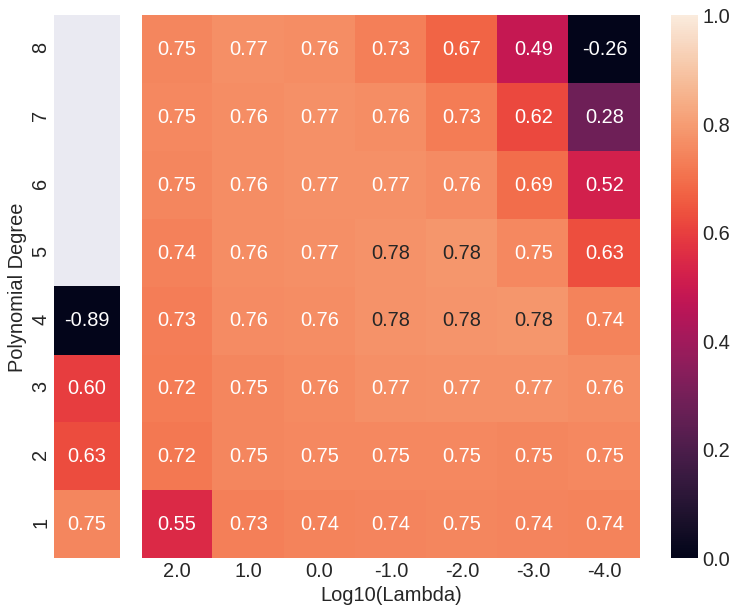

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,8), sharey=True, gridspec_kw={'width_ratios': [1, 9.5]})
sns.heatmap(r2_ridge.T, ax=ax[1], annot=True, fmt=".2f", vmin=0, vmax=1, xticklabels=np.log10(lambdas), yticklabels=degrees)#, cbar_kws={"fraction": 0.25, "pad": 0.05})
sns.heatmap(r2_OLS.T.reshape(-1,1), ax=ax[0], annot=True, fmt=".2f", vmin=0, vmax=1, yticklabels=degrees, xticklabels=False, cbar=False)
ax[0].set_ylabel("Polynomial Degree")
ax[1].set_xlabel("Log10(Lambda)")
plt.ylim(0, 8);
plt.tight_layout()
plt.savefig("../figs/WH_linreg_r2.pdf", bbox_inches="tight")

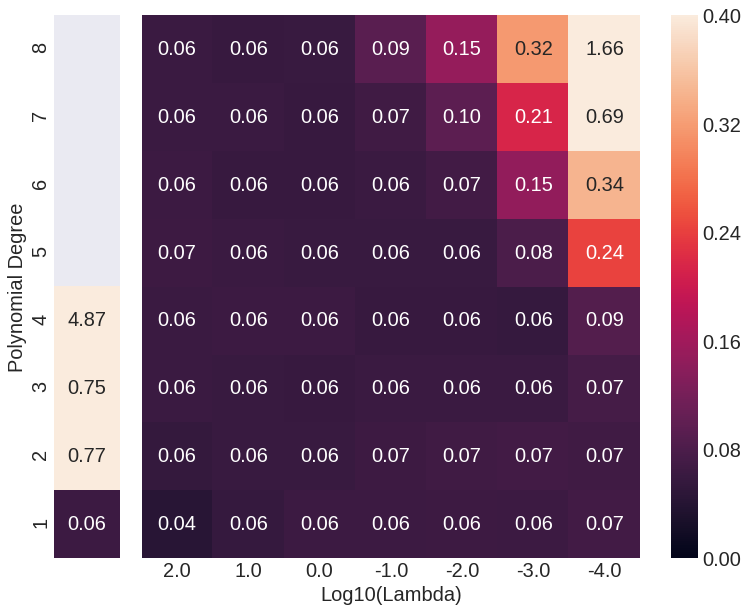

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10,8), sharey=True, gridspec_kw={'width_ratios': [1, 9.5]})
sns.heatmap(std_ridge.T, ax=ax[1], annot=True, fmt=".2f", vmin=0, vmax=0.4, xticklabels=np.log10(lambdas), yticklabels=degrees)#, cbar_kws={"fraction": 0.25, "pad": 0.05})
sns.heatmap(std_OLS.T.reshape(-1,1), ax=ax[0], annot=True, fmt=".2f", vmin=0, vmax=0.4, yticklabels=degrees, xticklabels=False, cbar=False)
ax[0].set_ylabel("Polynomial Degree")
ax[1].set_xlabel("Log10(Lambda)")
plt.ylim(0, 8);
plt.tight_layout()
plt.savefig("../figs/WH_linreg_std.pdf", bbox_inches="tight")